In [1]:
#from zsl_newstore import chunked_adgpm, chunked_eszsl, pp, plot
from semantics import select_lemmas, GloVe
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from utils import *
from zsl import *

%matplotlib inline

In [2]:
def test_eszsl_sample(trnodes, tenodes, df):
    v_tr = get_visu(trnodes)
    s_tr = get_sem(trnodes, df)
    v_te, s_te, l_te = get_data(tenodes, df)
    best = [0]
    for g in [0,1,10,100, 1000]:
        for l in [0,1,10,100, 1000]:
            w = get_W(v_tr, s_tr, g, l)
            res_ = scores(v_te, s_te, w)
            res = topk(res_, 5, l_te)
            if res[0]>best[0]:
                best=res
                ret = res_
    return ret, l_te

def assess(res, lbl, idx):
    result = np.zeros((2,2))
    X = res.topk(1)[1].squeeze().cpu().numpy()
    X = pd.Series(X, index=lbl.squeeze().cpu().numpy())
    X_ = X[idx].dropna().astype(int)
    st_se = 1-(adjmat[X_,X_.index]==0).mean()
    nost_se = (adjmat[X_,X_.index]==1).mean()
    st_nose = 1-(adjmat[X,X.index]==0).mean()
    nost_nose = (adjmat[X,X.index]==1).mean()
    result[0,0]=nost_nose
    result[0,1]=nost_se
    result[1,0]=st_nose
    result[1,1]=st_se
    return result

def get_data(synsets, df, storefile, maxsamp=100, ratio=1):
    """"""
    feats, lbls = [],[]
    with h5py.File(storefile, "r") as f:
        for i,wnid in tqdm.tqdm(enumerate(synsets)):
            if wnid in f:
                nsamp = min(ceil(f[wnid].shape[0]*ratio), maxsamp)
                feat  = f[wnid][:nsamp]
                feats += [torch.from_numpy(feat)]
                lbls  += [i]*feat.shape[0]
    lbls = torch.LongTensor(lbls).cuda().unsqueeze(1)
    feats= torch.cat(feats).cuda()
    sems = get_sem(synsets, df)
    return feats, sems, lbls

def build_eszsl_features(tenodes, trnodes, storefile, generalized=False):
    df = pd.read_pickle(word_vectors_path)
    test_feats, s_te, test_lbls = get_data(tenodes, df, storefile)
    if generalized:
        tenodes = tenodes+trnodes
        s_te = get_sem(tenodes, df)
    v_tr = get_visu(trnodes)
    s_tr = get_sem(trnodes, df)
    adjmat = makeadj(tenodes)
    return test_feats, test_lbls, v_tr, s_tr, s_te, adjmat

def test_eszsl_sample(trnodes, tenodes, storefile, gen=False):
    v_te, l_te, v_tr, s_tr, s_te, adjmat = build_eszsl_features(tenodes, trnodes, storefile, gen)
    best = [0]
    for g in [0,1,10,100, 1000]:
        for l in [0,1,10,100, 1000]:
            w = get_W(v_tr, s_tr, g, l)
            res_ = scores(v_te, s_te, w)
            res = topk(res_, 5, l_te)
            if res[0]>best[0]:
                best=res
                ret = res_
    return ret, l_te, adjmat

def build_adgpm_features(trnodes, tenodes,storefile,  gen=False):
    df = pd.read_pickle(fcgcn_path)
    test_feats, s_te, test_lbls = get_data(tenodes, df, storefile)
    if gen:
        tenodes = tenodes + trnodes 
        s_te = get_sem(tenodes, df)
    adjmat = makeadj(tenodes)
    return test_feats, test_lbls, s_te[:,:2048], adjmat

def test_adgpm_sample(trnodes, tenodes, storefile, gen=False):
    v_te, l_te, s_te, adjmat = build_adgpm_features(trnodes, tenodes, storefile, gen)
    best = 0
    for g in [0,1,10,100, 1000]:
        for l in [0,1,10,100, 1000]:
            res_ = v_te.mm(s_te.t())
            res = topk(res_, 5, l_te)[0]
            if res>best:
                best= res
                ret = res_
    return ret, l_te, adjmat

def plot(results):
    xlabels = ["Standard ZSL", "Generalized ZSL"]
    ylabels = ["Linear", "GCN"]
    labels  = np.asarray(['Model error', 'Accuracy', 'Visual', 'Structural', 'Semantic'])
    colors  = np.asarray(['#cc6600', "#006600", "#cccc00", '#739900', '#666666'])
    idx = np.asarray([0,1,3,2,4])
    shadow = True
    startangle=90
    autopct='%1.1f%%'
    lblfont = {'family': 'serif',
                    'size': 16,
            }

    fig, axes = plt.subplots(2,2, figsize=(10,10))

    for i,model in enumerate(["eszsl", "gcn"]):
        for j,generalized in enumerate([False, True]):
            res = results[(model, generalized)]
            x,_,_=axes[i,j].pie(np.asarray(res)[idx], 
                          #labels=labels[idx], 
                          colors=colors[idx], 
                          autopct=autopct, 
                          shadow=shadow, 
                          startangle=startangle)
            if i==1:
                axes[i,j].set_xlabel(xlabels[j], fontdict=lblfont)
            if j==0:
                axes[i,j].set_ylabel(ylabels[i], fontdict=lblfont)

    fig.legend(x, labels[idx], loc="center", fontsize=14)
    fig.savefig("./data/plots/global_error_distribution")
    
def summarize(res):
    res = np.concatenate(res)
    #res=res[:,0,:,:]
    tot = res[1,1,1] - res[0,0,0]
    x=np.asarray([(res.take(1,i)-res.take(0,i)).mean() for i,_ in enumerate(res.shape)])
    x=x*(tot/x.sum())
    res = [1-res[1,1,1], res[0,0,0]] + x.tolist()
    return res

In [ ]:
glove = GloVe()
wrdcount=get_wrdcount()
trnodes = get_split("train")
tenodes = get_split("2-hops")
adjmat = makeadj(tenodes)
df = pd.read_pickle(word_vectors_path)
synswords = select_lemmas(tenodes, {"wn":"strict"}, {"min":500, "max":10**8, "voc":glove.isin}, counter=wrdcount, glove=glove)
synsets = synswords[synswords.apply(lambda x:len(x)>0)]
idx = synsets.index.map(lambda x:tenodes.index(x)).values

In [28]:
cleanstore="./data/visu/New_resnet_50_feat"
fullstore = "/media/tristan/Samsung_T5/resnet_50_feat"
ESZSL_gen,ESZSL_std,GCN_gen,GCN_std = [],[],[],[]

for storefile in [fullstore, cleanstore]:
    ret, lbl, adjmat = test_eszsl_sample(trnodes, tenodes, storefile, True)
    res = assess(ret, lbl, idx)
    ESZSL_gen.append(res[None,:,:])
    ret, lbl, adjmat = test_eszsl_sample(trnodes, tenodes, storefile, False)
    res = assess(ret, lbl, idx)
    ESZSL_std.append(res[None,:,:])
    ret, lbl, adjmat = test_adgpm_sample(trnodes, tenodes, storefile, True)
    res = assess(ret, lbl, idx)
    GCN_gen.append(res[None,:,:])
    ret, lbl, adjmat = test_adgpm_sample(trnodes, tenodes, storefile, False)
    res = assess(ret, lbl, idx)
    GCN_std.append(res[None,:,:])

In [ ]:
res = summarize(GCN_std)

results = {("gcn", True):summarize(np.concatenate(GCN_gen)),
           ("gcn", False):summarize(np.concatenate(GCN_std)),
           ("eszsl", True):summarize(np.concatenate(ESZSL_gen)),
           ("eszsl", False):summarize(np.concatenate(ESZSL_std))
          }

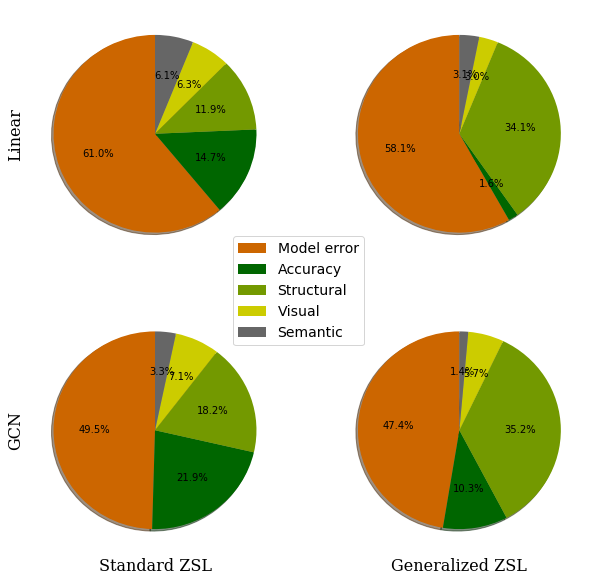

In [13]:
results = {("gcn", True):   [47.4, 10.3, 5.7,  35.2, 1.4],
           ("gcn", False):  [49.4, 21.8, 7.1,  18.1, 3.3],
           ("eszsl", False):[61.0, 14.7, 6.3,  11.9, 6.1],
           ("eszsl", True): [66.8, 1.8,  3.5,  39.2, 3.6]
          }

plot(results)

# GCN Results